### **Identifying Cell Trajectories with MAGIK**

Cell tracking is a crucial step in the analysis of time-lapse microscopy images. It allows us to study the behavior of individual cells over time, providing insights into cell division, migration, and other dynamic processes. 

This tutorial exemplifies how to apply a pretrained [MAGIK](https://www.nature.com/articles/s42256-022-00595-0) (Motion Analysis Through Graph Inductive Knowledge) model to your own data for cell tracking.

#### **Loading the Test Data**

Start by loading the test data:

In [3]:
import glob
import cv2

def load_images(path):
    images = []
    for file in glob.glob(path + "/*.tif"): # (1)
        image = cv2.imread(file, cv2.IMREAD_UNCHANGED) # (2)
        images.append(image) # (3)

    return images

test_image_path = "path/to/test/images"
test_segmentation_path = "path/to/test/segmentation/masks"

test_images = load_images(test_image_path)
test_segmentations = load_images(test_segmentation_path)

This script 
**(1)** iterates over each file in the specified directory path containing a `.tif` extension (modify the extension if your images are in a different format), 
**(2)** reads the image using OpenCV's `cv2.imread()` function with the `IMREAD_UNCHANGED flag` indicating that the image should be loaded without any modification or conversion, 
and **(3)** appends the loaded image to the `images` list.

Let us visualize some frames from the test image sequence along with their corresponding segmentation mask.

The script below plots a specified number of frames distributed evenly over the test image sequence.

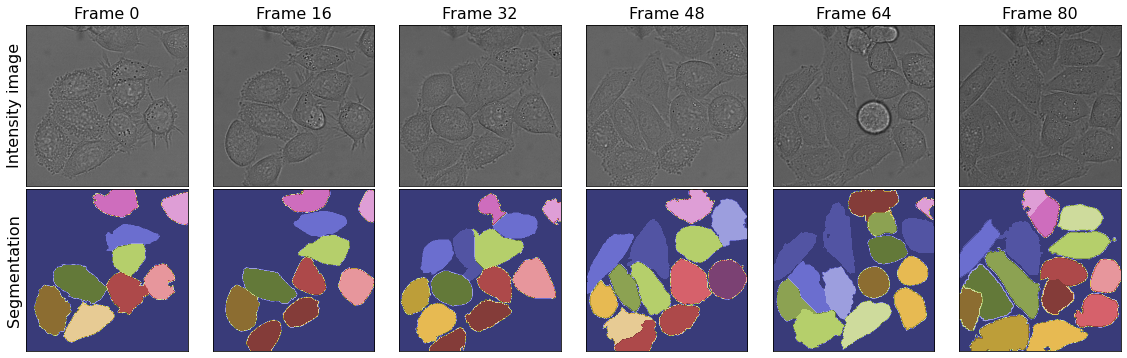

In [4]:
import matplotlib.pyplot as plt

number_of_frames = 5

total_frames = len(test_segmentations) 

plot_interval = total_frames // number_of_frames 
frames_to_plot = [i for i in range(0, total_frames, plot_interval)]

fig, axs = plt.subplots(2, number_of_frames + 1, figsize=(20, 6))
fig.patch.set_facecolor('white')

for i, frame in enumerate(frames_to_plot):
    if i == 0:
        axs[0, i].set_ylabel("Intensity image", fontsize=16)
        axs[1, i].set_ylabel("Segmentation", fontsize=16)

    axs[0, i].imshow(test_images[frame], cmap='gray')
    axs[0, i].set_title(f"Frame {frame}", fontsize=16)
    axs[0, i].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False)

    # Plot segmentation
    axs[1, i].imshow(test_segmentations[frame], cmap='tab20b')
    axs[1, i].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False)

plt.subplots_adjust(wspace=0.02, hspace=0.02)
plt.show()

#### **Building the Test Graph**

MAGIK models cell motion and interactions as a directed graph, where nodes represent segmented cells and edges connect spatially close cells across frames.

We will implement the `GraphFromSegmentations` class to generate a graph from the segmented video frames:

In [5]:
import numpy as np
from skimage import measure

import torch
from torch_geometric.data import Data


class GraphFromSegmentations:
    def __init__(self, connectivity_radius, max_frame_distance):
        self.connectivity_radius = connectivity_radius # (1)
        self.max_frame_distance = max_frame_distance # (2)

    def __call__(self, images, segmentations, relation):
        x, node_index_labels, frames = [], [], []
        for frame, (image, segmentation) in enumerate(zip(images, segmentations)): # (3)
            features, index_labels = self.compute_node_features(image, segmentation) # (4)

            x.append(features) # (5)
            node_index_labels.append(index_labels) # (6)
            frames.append([frame] * len(features)) # (7)

        x = np.concatenate(x)
        node_index_labels = np.concatenate(node_index_labels)
        frames = np.concatenate(frames)

        edge_index, edge_attr = self.compute_connectivity(x, frames) # (8)
        edge_ground_truth = self.compute_ground_truth( # (9)
            node_index_labels, edge_index, relation
        )

        edge_index = edge_index.T
        edge_attr = edge_attr[:, None]
        edge_ground_truth = edge_ground_truth[:, None]

        graph = Data( # (10)
            x=torch.tensor(x, dtype=torch.float),
            edge_index=torch.tensor(edge_index, dtype=torch.long),
            edge_attr=torch.tensor(edge_attr, dtype=torch.float),
            distance=torch.tensor(edge_attr, dtype=torch.float),
            frames=torch.tensor(frames, dtype=torch.float),
            y=torch.tensor(edge_ground_truth, dtype=torch.float),
        )

        return graph

    def compute_node_features(self, image, segmentation):
        labels = np.unique(segmentation)

        x, indices = [], []
        for label in labels[1:]:
            mask = segmentation == label
            props = measure.regionprops(mask.astype(np.int32), intensity_image=image)[0]

            centroids = props.centroid / np.array(segmentation.shape)

            x.append([*centroids])
            indices.append(label)

        return x, indices

    def compute_connectivity(self, x, frames):
        positions = x[:, :2]
        distances = np.linalg.norm(positions[:, None] - positions, axis=-1)

        frame_diff = (frames[:, None] - frames) * -1

        mask = (distances < self.connectivity_radius) & ( 
            (frame_diff <= self.max_frame_distance) & (frame_diff > 0)
        )

        edge_index = np.argwhere(mask) 
        edge_attr = distances[mask] 

        return edge_index, edge_attr

    def compute_ground_truth(self, indices, edge_index, relation):
        sender = indices[edge_index[:, 0]] 
        receiver = indices[edge_index[:, 1]]
        self_connections_mask = sender == receiver

        if relation is None:
            return self_connections_mask
        
        relation_indices = relation[:, [-1, 0]] 
        relation_indices = relation_indices[relation_indices[:, 0] != 0]

        relation_mask = np.zeros(len(edge_index), dtype=bool)
        for i, (s, r) in enumerate(zip(sender, receiver)):
            if np.any((relation_indices == [s, r]).all(1)): 
                relation_mask[i] = True

        return self_connections_mask | relation_mask

The `GraphFromSegmentations` class is initialized with two parameters: **(1)** `connectivity_radius` and **(2)** `max_frame_distance`. These parameters play an important role in establishing the spatial and temporal thresholds necessary for determining connectivity between nodes within the graph structure.

In the call method, `GraphFromSegmentations` receives two inputs: the segmented video frames (`segmentations`) and the parent-child relationships between cells (`relation`). **(3)** The method identifies separate objects in each frame of the segmented video data using their index labels. Next, **(4)** it calculates relevant features such as normalized centroids and eccentricity. **(5)** These features are stored in a set called `x`. The algorithm repeats this process for every object in the frame, creating a collection of node features (`x`), **(6)** index labels (`node_index_labels`), and **(7)** their corresponding frame numbers (`frames`), all poised for further processing.

Leveraging the extracted node features, **(8)** `GraphFromSegmentations` proceeds to calculate pairwise distances between the positions of the nodes. Simultaneously, it computes the temporal difference between frames. Based on the specified thresholds (`connectivity_radius` and `max_frame_distance`), it identifies nodes that are both spatially and temporally close. The result is a set of edge indices (`edge_index`) and corresponding distances (`edge_attr`) representing the connectivity between nodes.

Finally, **(9)** the ground-truth edges are computed. The generated graph includes a redundant number of edges with respect to the actual associations between cells. MAGIK aims to prune the redundant edges while retaining the true connections. Therefore, the ground truth for each edge is a binary value indicating whether an edge should connect two detections, i.e., an edge classification problem. `GraphFromSegmentations` defines the ground truth by comparing the node index labels and parent-child relationships. Firstly, it identifies self-connections where sender and receiver nodes have the same node index labels. Next, it explores the cell relationships to find relational connections, such as cell divisions. The ground truths are derived from the combination of self-connections and relational connections. 

**(10)** `GraphFromSegmentations` constructs a PyTorch Data object using node features, edge indices, attributes, distances, frames, and ground truth. This object encapsulates all necessary information for training and testing.

Instantiate the `GraphFromSegmentations` class using a connectivity radius and maximum frame distance that match the values used during training.

In [6]:
graph_constructor = GraphFromSegmentations(connectivity_radius=0.2, max_frame_distance=2)

We now construct the test graph using `graph_constructor`:

In [8]:
test_graph = graph_constructor(test_images, test_segmentations, relation=None)

Use the following code to explore the graph data structure:

In [9]:
print("Number of nodes:", len(test_graph.x))
print("Number of edges:", len(test_graph.edge_index[0]))

Number of nodes: 1104
Number of edges: 3652


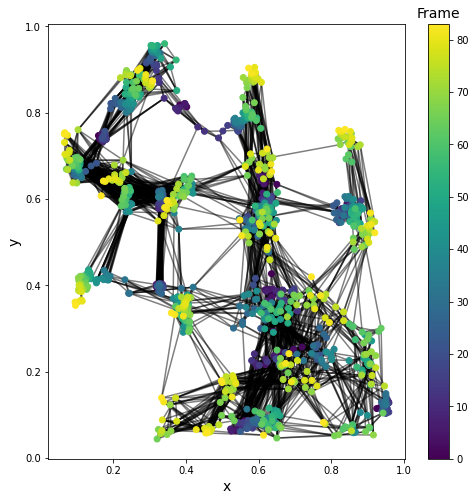

In [10]:
plt.figure(figsize=(8, 8))

for i, j in test_graph.edge_index.T:
    plt.plot(
        [test_graph.x[i, 1], test_graph.x[j, 1]],
        [test_graph.x[i, 0], test_graph.x[j, 0]],
        c="black",
        alpha=0.5,
    )

plt.scatter(
    test_graph.x[:, 1],
    test_graph.x[:, 0],
    c=test_graph.frames,
    cmap="viridis",
    zorder=10,
)
# label colorbar
cb = plt.colorbar()
cb.ax.set_title('Frame', fontsize=14)
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)

plt.show()

This scatter plot depicts a graph with nodes represented as dots. The $x$ and $y$ coordinates represent the normalized node centroids. The color of each dot corresponds to the frame number, as shown on the color bar. The black lines on the plot illustrate the edges.

#### **Loading the Pretrained Model**

The following code snippet defines **MAGIK** and loads the pretrained model:

In [22]:
from deeplay import GraphToEdgeMAGIK
import torch.nn as nn

model = GraphToEdgeMAGIK([96,] * 4, 1, out_activation=nn.Sigmoid)
model = model.create()

path = "model/model_state_dict.pt"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

#### **Predicting Cell Trajectories**

Now, we can predict cell trajectories using the pretrained model:

In [23]:
model.eval()
pred = model(test_graph)
predictions = pred.detach().numpy() > 0.5

Note that MAGIK does not output cell trajectories, but a graph structure that shows the connections between cells across frames. To generate cell trajectories, a post-processing algorithm is applied to the predicted graph structure.

The `compute_trajectories` function below implements a simple post-processing algorithm to compute cell trajectories from MAGIK predictions. This might be refined based on edge probability to improve the results, e.g., as done in the file `post.py` in the `\SW\lib` folder. 

In [24]:
import networkx as nx

class compute_trajectories:

    def __call__(self, graph, predictions):
        pruned_edges = self.prune_edges(graph, predictions)

        pruned_graph = nx.Graph()
        pruned_graph.add_edges_from(pruned_edges)

        trajectories = list(nx.connected_components(pruned_graph))

        return trajectories

    def prune_edges(self, graph, predictions):
        pruned_edges = []

        frame_pairs = np.stack(
            [graph.frames[graph.edge_index[0]], graph.frames[graph.edge_index[1]]],
            axis=1,
        )

        senders = np.unique(graph.edge_index[0])
        for sender in senders: 
            sender_mask = graph.edge_index[0] == sender # (1)
            candidate = predictions[sender_mask] == True # (2)

            frame_diff = frame_pairs[sender_mask, 1] - frame_pairs[sender_mask, 0]
            candidates_frame_diff = frame_diff[candidate]

            if not np.any(candidate):
                continue
            else:
                candidate_min_frame_diff = candidates_frame_diff.min()
            
            candidate_edge_index = graph.edge_index[:, sender_mask][ # (3)
                :, candidate & (frame_diff == candidate_min_frame_diff)
            ]
            candidate_edge_index = candidate_edge_index.reshape(-1, 2)

            if len(candidate_edge_index) == 1: # (4)
                pruned_edges.append(tuple(*candidate_edge_index.numpy()))

        return pruned_edges

post_processor = compute_trajectories()

**(1)** The algorithm starts by selecting a node in the first frame ($t=0$) and then links it to other nodes in the following frames, **(2)** using only edges labeled as "linked" by MAGIK. **(3)** If there are no "linked" edges connecting the sender node at time $t$ to any receiver nodes at time $t+1$, the algorithm checks future frames up to a maximum time delay. If no "linked" edges are found within this timeframe, the trajectory ends.

When a sender node has two "linked" edges connecting it to two receiver nodes in a later frame, it's identified as a division. In this case, **(4)** the algorithm creates two new trajectories. This process repeats until all "linked" edges are dealt with.

In [25]:
trajectories = post_processor(test_graph, predictions.squeeze())

Finally, we proceed to visualize the computed cell trajectories on top of the segmented video frames:

In [26]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from skimage import measure
import matplotlib.pyplot as plt

size = test_segmentations[0].shape

fig, ax = plt.subplots(figsize=(8, 8))

list_of_colors = plt.cm.get_cmap("tab20b", len(trajectories))
np.random.shuffle(list_of_colors.colors)

def update(frame):
    ax.clear()
    ax.imshow(test_images[frame], cmap="gray")

    segmentation = test_segmentations[frame]
    labels = np.unique(segmentation)

    for label in labels[1:]:
        contour = measure.find_contours(segmentation == label, 0.5)[0]
        ax.fill(
            contour[:, 1],
            contour[:, 0],
            color="purple",
            alpha=0.2,
            linewidth=6,
        )

    for idx, t in enumerate(trajectories):
        coordinates = test_graph.x[list(t)]
        frames = test_graph.frames[list(t)]

        coordinates_in_frame = coordinates[frames == frame]

        if len(coordinates_in_frame) == 0:
            continue

        ax.scatter(coordinates_in_frame[:, 1] * 512, coordinates_in_frame[:, 0] * 512, color="purple")

        coordinates_previous_frames = coordinates[
                (frames <= frame) & (frames >= frame - 10)
        ]
        f = frames[(frames <= frame) & (frames >= frame - 10)]
        coordinates_previous_frames = coordinates_previous_frames[np.argsort(f[f <= frame])]
        ax.plot(
            coordinates_previous_frames[:, 1] * 512,
            coordinates_previous_frames[:, 0] * 512,
            color="white",
        )

        ax.plot(
            coordinates_in_frame[max(0, frame - 10) : frame, 1] * 512,
            coordinates_in_frame[max(0, frame - 10) : frame, 0] * 512,
            color="red",
        )

    return ax


ani = FuncAnimation(fig, update, frames=len(test_segmentations))

#html_video = HTML(ani.to_jshtml())
html_video = HTML(ani.to_html5_video())

plt.close()
html_video

#### **Saving results**

Save the predicted graph representation using the following code snippet:

In [27]:
import os

if not os.path.exists("results"):
    os.makedirs("results")

predicted_graph = Data()

# Node coordinates
predicted_graph.x = test_graph.x[:, :2]
# Edge index
predicted_graph.edge_index = test_graph.edge_index
# Predictions
predicted_graph.prediction = predictions
# Frames
predicted_graph.frames = test_graph.frames
# Ground truth
predicted_graph.gt = test_graph.y

torch.save(predicted_graph, f"results/predicted_graph.pt")